In [3]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt

### Creating a one bus for the Netherlands

In [4]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)


network.add("Bus", "electricity bus", carrier="electricity")
network.add("Carrier", "electricity")  

network.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

#### Getting the demand for the Netherlands and adding it to the bus

In [5]:
# Define file path
file_path = "Data/electricity_demand.csv"

# Load dataset
data = pd.read_csv(file_path, sep=';', parse_dates=['utc_time'], index_col='utc_time')
data.index = pd.to_datetime(data.index, utc=True)
# Convert index to datetime format
data.index = pd.to_datetime(data.index, utc=True)

start_date = '2015-01-01 00:00:00+00:00'
end_date = '2015-12-31 23:00:00+00:00'

data = data[start_date:end_date]
country = 'NLD'
data = data[country]
print(data.head())

utc_time
2015-01-01 00:00:00+00:00    11338.0
2015-01-01 01:00:00+00:00    10917.0
2015-01-01 02:00:00+00:00    10473.0
2015-01-01 03:00:00+00:00    10200.0
2015-01-01 04:00:00+00:00    10182.0
Name: NLD, dtype: float64


In [6]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set = data.values)

Index(['load'], dtype='object')

In [7]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,11338.0
2015-01-01 01:00:00,10917.0
2015-01-01 02:00:00,10473.0
2015-01-01 03:00:00,10200.0
2015-01-01 04:00:00,10182.0
...,...
2015-12-31 19:00:00,12958.0
2015-12-31 20:00:00,12263.0
2015-12-31 21:00:00,11772.0


#### Adding different generation types 

In [8]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n
    
print(annuity(25,0.07))
print(annuity(25,0.07)*425000*(1+0.03))

0.0858105172206656
37563.55391334636


In [9]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "coal", co2_emissions=0.363) # in /MWh_tt_CO2h
network.add("Carrier", "offshorewind")
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")
network.add("Carrier", "nuclear")
network.add("Carrier", "gas", co2_emissions=0.22) # in /MWh_tt_CO2h



# add onshore wind generator
df_onshorewind = pd.read_csv('Data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind_on = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(30,0.07)*1088000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=7000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_on.values)

# add offshore wind generator
df_offshorewind = pd.read_csv('Data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
CF_wind_off = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_offshorewind = annuity(30,0.07)*2084520*(1+0.033) # in €/MW
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=7000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_off.values)

# add solar PV generator
df_solar = pd.read_csv('Data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*600290*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# add Gas CC W/o ccts
capital_cost_CCGT = annuity(30,0.07)*1300000*(1+0.033) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.58 # MWh_elec/MWh_th
VOM_gas = 4 # in €/MWh
marginal_cost_CCGT = VOM_gas + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "CCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=7000,
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)


# add coal power plant  generator coal IGCC W/o ccts
capital_cost_coal = annuity(40,0.07)*3088000*(1+0.03) # in €/MW
fuel_cost = 8.4 # in €/MWh_th
efficiency = 0.392 # MWh_elec/MWh_th
VOM_coal = 6 # in €/MWh
marginal_cost_coal = VOM_coal + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "coal",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=7000,
            capital_cost = capital_cost_coal,
            marginal_cost = marginal_cost_coal)


# add nuclear power plant generator
capital_cost_nuclear = annuity(45,0.07)*8594000*(1+0.027) # in €/MW
fuel_cost = 3 # in €/MWh_th 
efficiency = 0.33 # MWh_elec/MWh_th
VOM_nuclear = 10 # in €/MWh
marginal_cost_nuclear = VOM_nuclear + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "nuclear",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="nuclear",
            #p_nom_max=7000,
            capital_cost = capital_cost_nuclear,
            marginal_cost = marginal_cost_nuclear)

Index(['nuclear'], dtype='object')

In [10]:
network.generators_t.p_max_pu

Generator,offshorewind,onshorewind,solar
snapshot,,,
2015-01-01 00:00:00,0.734,0.360,0.0
2015-01-01 01:00:00,0.758,0.383,0.0
2015-01-01 02:00:00,0.787,0.417,0.0
2015-01-01 03:00:00,0.794,0.432,0.0
2015-01-01 04:00:00,0.802,0.443,0.0
...,...,...,...
2015-12-31 19:00:00,0.798,0.448,0.0
2015-12-31 20:00:00,0.798,0.465,0.0
2015-12-31 21:00:00,0.794,0.451,0.0


In [11]:
network.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]
INFO:linopy.io: Writing time: 2.8s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-ljf_szyh.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-ljf_szyh.lp


Reading time = 0.66 seconds


INFO:gurobipy:Reading time = 0.66 seconds


obj: 113886 rows, 52566 columns, 205855 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 205855 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 205855 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 205855 nonzeros


Model fingerprint: 0x3c640133


INFO:gurobipy:Model fingerprint: 0x3c640133


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [2e+01, 6e+05]


INFO:gurobipy:  Objective range  [2e+01, 6e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [9e+03, 2e+04]


INFO:gurobipy:  RHS range        [9e+03, 2e+04]


Presolve removed 56957 rows and 4391 columns


INFO:gurobipy:Presolve removed 56957 rows and 4391 columns


Presolve time: 0.33s


INFO:gurobipy:Presolve time: 0.33s


Presolved: 56929 rows, 48175 columns, 144507 nonzeros


INFO:gurobipy:Presolved: 56929 rows, 48175 columns, 144507 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 9.634e+04


INFO:gurobipy: AA' NZ     : 9.634e+04


 Factor NZ  : 5.298e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 5.298e+05 (roughly 50 MB of memory)


 Factor Ops : 5.161e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.161e+06 (less than 1 second per iteration)


 Threads    : 3


INFO:gurobipy: Threads    : 3


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.12042615e+10  0.00000000e+00  1.21e+05 0.00e+00  3.47e+07     1s


INFO:gurobipy:   0   7.12042615e+10  0.00000000e+00  1.21e+05 0.00e+00  3.47e+07     1s


   1   9.82768411e+10 -1.37686853e+11  1.87e+04 3.77e+02  8.34e+06     1s


INFO:gurobipy:   1   9.82768411e+10 -1.37686853e+11  1.87e+04 3.77e+02  8.34e+06     1s


   2   7.45988782e+10 -6.18488891e+10  2.18e-11 3.00e-09  9.44e+05     1s


INFO:gurobipy:   2   7.45988782e+10 -6.18488891e+10  2.18e-11 3.00e-09  9.44e+05     1s


   3   2.09518986e+10 -1.31506479e+09  1.46e-10 9.44e-10  1.54e+05     1s


INFO:gurobipy:   3   2.09518986e+10 -1.31506479e+09  1.46e-10 9.44e-10  1.54e+05     1s


   4   1.51822513e+10  1.87934294e+09  1.60e-10 1.75e-09  9.21e+04     1s


INFO:gurobipy:   4   1.51822513e+10  1.87934294e+09  1.60e-10 1.75e-09  9.21e+04     1s


   5   1.29971349e+10  3.39551298e+09  6.69e-10 1.37e-09  6.64e+04     1s


INFO:gurobipy:   5   1.29971349e+10  3.39551298e+09  6.69e-10 1.37e-09  6.64e+04     1s


   6   1.27064316e+10  3.65177951e+09  1.05e-09 1.07e-09  6.27e+04     1s


INFO:gurobipy:   6   1.27064316e+10  3.65177951e+09  1.05e-09 1.07e-09  6.27e+04     1s


   7   1.21656371e+10  4.38062951e+09  2.84e-09 1.32e-09  5.39e+04     1s


INFO:gurobipy:   7   1.21656371e+10  4.38062951e+09  2.84e-09 1.32e-09  5.39e+04     1s


   8   9.55544032e+09  5.63402811e+09  7.64e-08 1.13e-09  2.71e+04     1s


INFO:gurobipy:   8   9.55544032e+09  5.63402811e+09  7.64e-08 1.13e-09  2.71e+04     1s


   9   8.43698953e+09  6.15454091e+09  8.12e-08 1.06e-09  1.58e+04     1s


INFO:gurobipy:   9   8.43698953e+09  6.15454091e+09  8.12e-08 1.06e-09  1.58e+04     1s


  10   7.77650521e+09  6.31018857e+09  4.43e-08 1.40e-09  1.01e+04     1s


INFO:gurobipy:  10   7.77650521e+09  6.31018857e+09  4.43e-08 1.40e-09  1.01e+04     1s


  11   7.43422727e+09  6.39164970e+09  1.09e-07 1.14e-09  7.21e+03     1s


INFO:gurobipy:  11   7.43422727e+09  6.39164970e+09  1.09e-07 1.14e-09  7.21e+03     1s


  12   7.26028262e+09  6.44387350e+09  1.63e-07 1.81e-09  5.65e+03     2s


INFO:gurobipy:  12   7.26028262e+09  6.44387350e+09  1.63e-07 1.81e-09  5.65e+03     2s


  13   7.16081364e+09  6.50334073e+09  2.49e-07 4.95e-10  4.55e+03     2s


INFO:gurobipy:  13   7.16081364e+09  6.50334073e+09  2.49e-07 4.95e-10  4.55e+03     2s


  14   6.99223976e+09  6.52673635e+09  2.01e-07 7.19e-10  3.22e+03     2s


INFO:gurobipy:  14   6.99223976e+09  6.52673635e+09  2.01e-07 7.19e-10  3.22e+03     2s


  15   6.91737560e+09  6.54335248e+09  6.96e-08 8.40e-10  2.59e+03     2s


INFO:gurobipy:  15   6.91737560e+09  6.54335248e+09  6.96e-08 8.40e-10  2.59e+03     2s


  16   6.87199549e+09  6.54851468e+09  2.08e-08 7.02e-10  2.24e+03     2s


INFO:gurobipy:  16   6.87199549e+09  6.54851468e+09  2.08e-08 7.02e-10  2.24e+03     2s


  17   6.69489483e+09  6.55876395e+09  6.00e-07 2.77e-09  9.42e+02     2s


INFO:gurobipy:  17   6.69489483e+09  6.55876395e+09  6.00e-07 2.77e-09  9.42e+02     2s


  18   6.60756552e+09  6.56920000e+09  5.07e-07 3.96e-09  2.65e+02     2s


INFO:gurobipy:  18   6.60756552e+09  6.56920000e+09  5.07e-07 3.96e-09  2.65e+02     2s


  19   6.60299742e+09  6.56992570e+09  4.43e-07 1.48e-09  2.29e+02     2s


INFO:gurobipy:  19   6.60299742e+09  6.56992570e+09  4.43e-07 1.48e-09  2.29e+02     2s


  20   6.59815285e+09  6.57054180e+09  3.76e-07 5.46e-10  1.91e+02     2s


INFO:gurobipy:  20   6.59815285e+09  6.57054180e+09  3.76e-07 5.46e-10  1.91e+02     2s


INFO:gurobipy:


Barrier performed 20 iterations in 2.30 seconds (0.49 work units)


INFO:gurobipy:Barrier performed 20 iterations in 2.30 seconds (0.49 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   39611    6.5737120e+09   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   39611    6.5737120e+09   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 39611 iterations and 2.54 seconds (0.98 work units)


INFO:gurobipy:Solved in 39611 iterations and 2.54 seconds (0.98 work units)


Optimal objective  6.573712049e+09


INFO:gurobipy:Optimal objective  6.573712049e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 6.57e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [12]:
print(network.objective/1000000) #in 10^6 €

6573.712049064885


In [13]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    58.046086
dtype: float64


In [14]:
network.generators.p_nom_opt # in MW

Generator
onshorewind      1083.333333
offshorewind        0.000000
solar               0.000000
CCGT            17545.250000
coal                0.000000
nuclear             0.000000
Name: p_nom_opt, dtype: float64

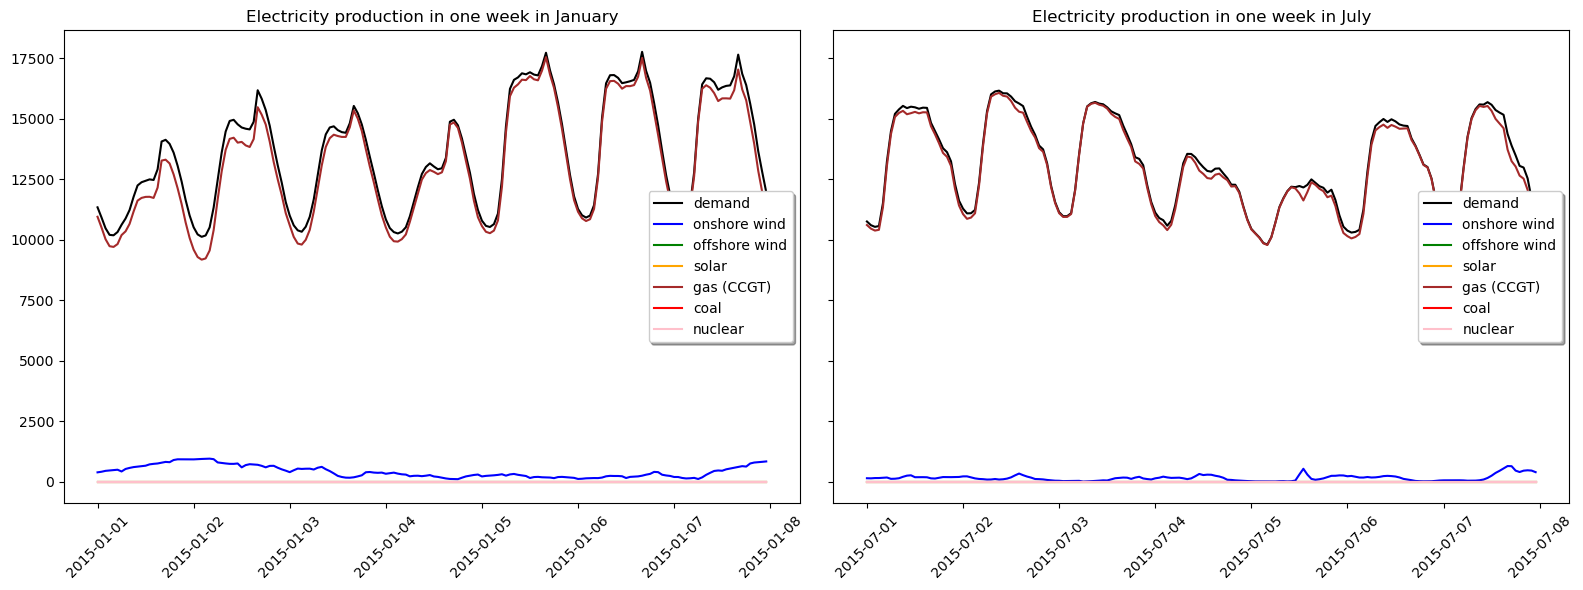

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Electricity mix

Text(0.5, 1.07, 'Electricity mix')

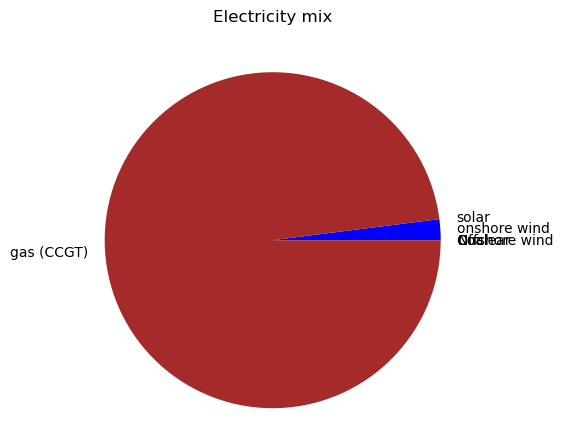

In [16]:
labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum(),
        network.generators_t.p['nuclear'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'red', 'pink']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [17]:
# Group dispatch by carrier manually
dispatch = network.generators_t.p
carrier_map = network.generators.carrier

# Match generator names to carriers
dispatch.columns = carrier_map[dispatch.columns].values

C:\Users\Change\AppData\Local\Temp\ipykernel_14148\1457957073.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



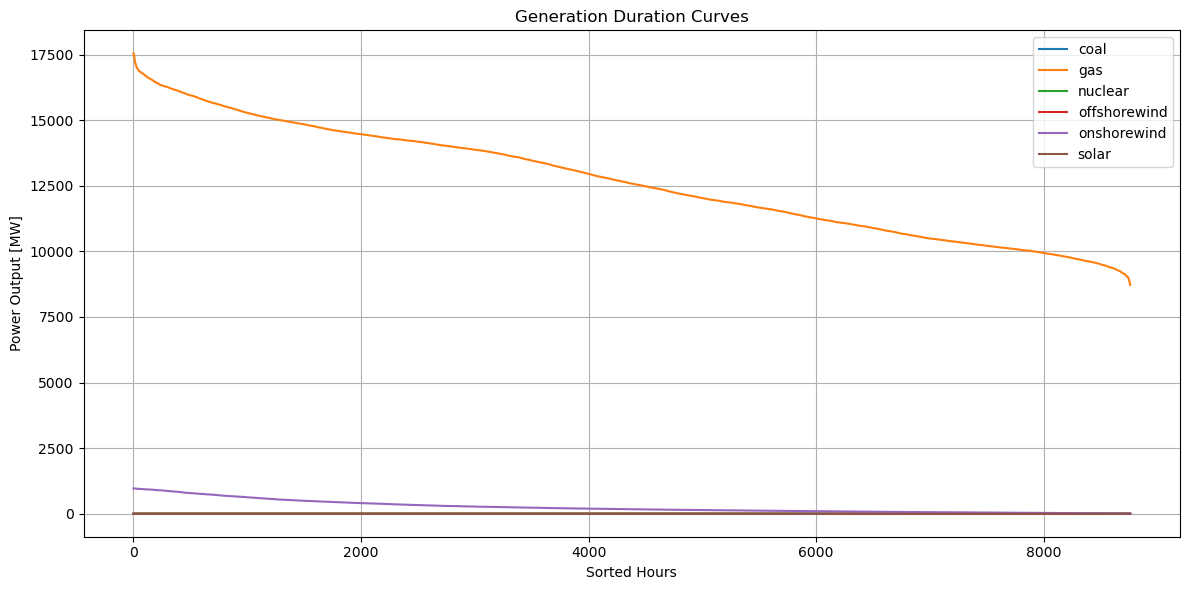

In [18]:
# Sum all generators by carrier
carrier_dispatch = dispatch.groupby(axis=1, level=0).sum()
# Duration curves
carrier_dispatch.apply(lambda x: x.sort_values(ascending=False).reset_index(drop=True)).plot(
    figsize=(12, 6), title="Generation Duration Curves")
plt.ylabel("Power Output [MW]")
plt.xlabel("Sorted Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

## CO2 limit 

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]
INFO:linopy.io: Writing time: 3.76s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-4gicy6ju.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-4gicy6ju.lp


Reading time = 0.79 seconds


INFO:gurobipy:Reading time = 0.79 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 6.92e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Generator
onshorewind     20301.695437
offshorewind        0.000000
solar           14475.825252
CCGT            17372.284741
coal                0.000000
nuclear             0.000000
Name: p_nom_opt, dtype: float64

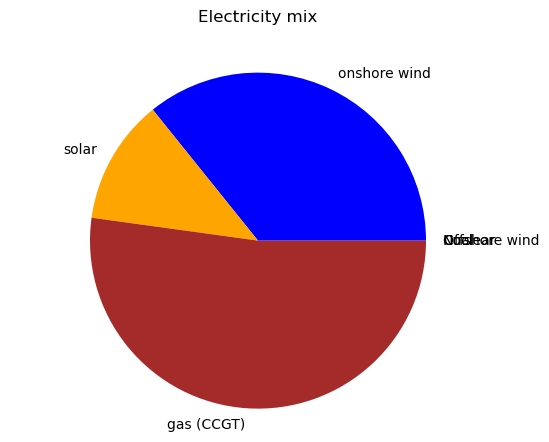

In [19]:
co2_limit=13000000#tonCO2
network.add("GlobalConstraint",
            "co2_limit_13MT",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)

#network.optimize(solver_name='gurobi')
network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})



labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum(),
        network.generators_t.p['nuclear'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'red', 'pink']    

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

network.generators.p_nom_opt # in MW

In [20]:
print(network.objective/1000000) #in 10^6 €

6923.799911090639


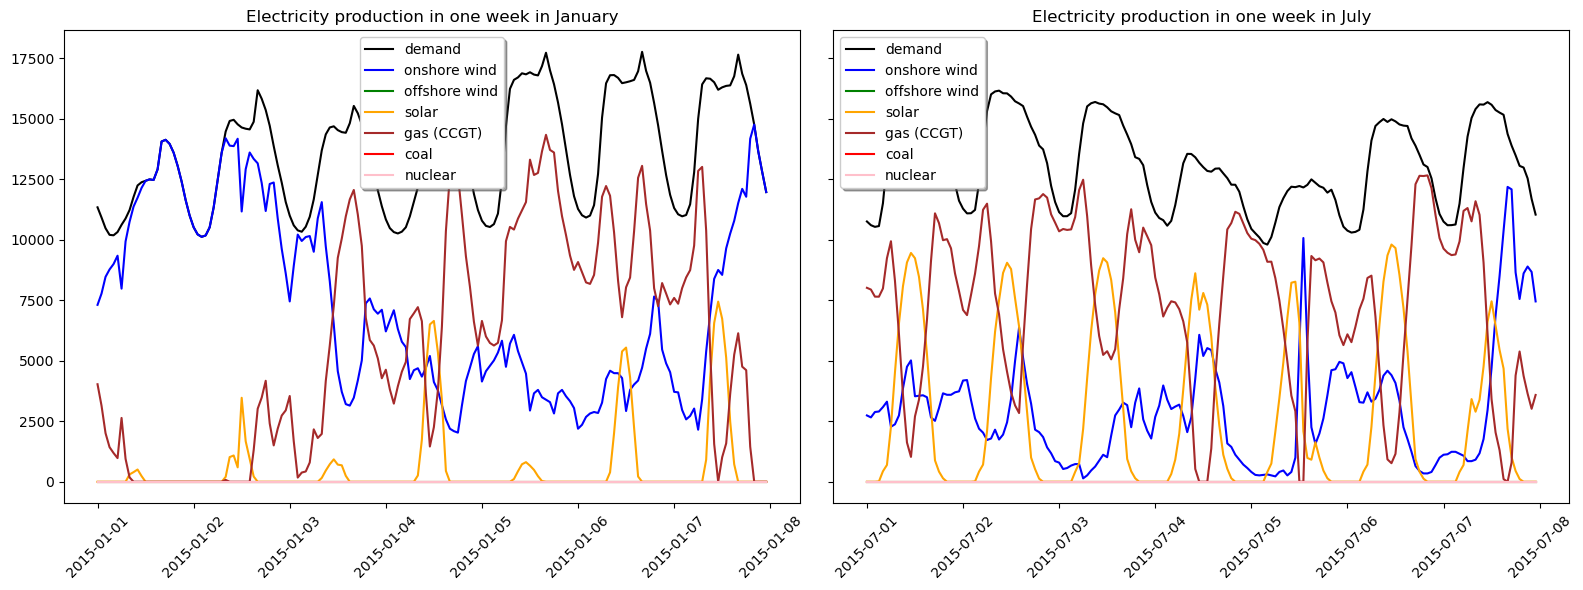

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Part C. Plotting Average Capacity and variability for every generator

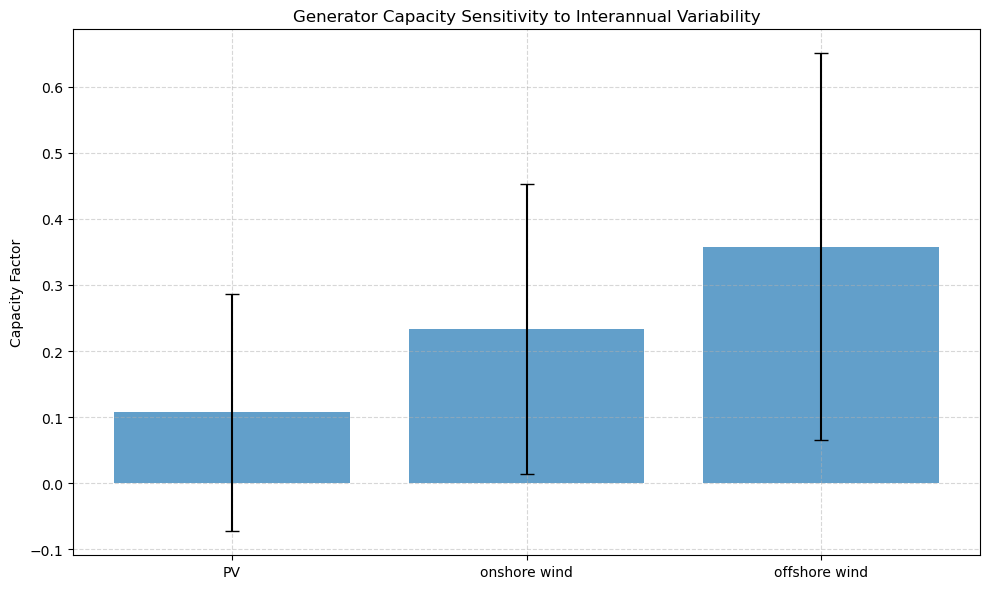

In [22]:
#calculating the average capacity for each generator using different years
Country = 'NLD'

data_pv = pd.read_csv('Data/pv_optimal.csv', sep=';', index_col=0)
data_pv.index = pd.to_datetime(data_pv.index)
CF_pv = data_pv[country]['1979-1-01T00:00:00Z':'2017-12-31T23:00:00Z']

data_onshore_wind = pd.read_csv('Data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
data_onshore_wind.index = pd.to_datetime(data_onshore_wind.index)
CF_onshore_wind = data_onshore_wind[country]['1979-1-01T00:00:00Z':'2017-12-31T23:00:00Z']

data_offshore_wind = pd.read_csv('Data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
data_offshore_wind.index = pd.to_datetime(data_offshore_wind.index)
CF_offshore_wind = data_offshore_wind[country]['1979-1-01T00:00:00Z':'2017-12-31T23:00:00Z']

CF_all = pd.concat([CF_pv.rename('PV'),
                    CF_onshore_wind.rename('onshore wind'),
                    CF_offshore_wind.rename('offshore wind')], axis=1)

average = CF_all.mean()
std_dev = CF_all.std()

plt.figure(figsize=(10, 6))
plt.bar(average.index, average.values, yerr=std_dev.values, capsize=5, alpha = 0.7)
plt.ylabel('Capacity Factor')
plt.title('Generator Capacity Sensitivity to Interannual Variability')
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()






Part D. Adding Storage Technology

In [23]:
network.add("Carrier", "battery")
network.add("Carrier", "Pumped Hydro")

# add storage units (battery and pumped hydro)
network.add("StorageUnit", "battery", 
            bus="electricity bus",
            p_nom=300000,
            max_hours=4.5,
            p_nom_extendable = True,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=350000,
            marginal_cost=0,
            carrier="battery",
            overwrite = True)

network.add("StorageUnit", "Pumped Hydro", 
            bus="electricity bus",
            p_nom=500,
            p_nom_extendable = True,
            max_hours=12,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=2000000,
            marginal_cost=0,
            carrier="Pumped Hydro",
            overwrite = True)


Index(['Pumped Hydro'], dtype='object')

In [24]:
network.storage_units.head(3)

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
battery,electricity bus,PQ,,300000.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,4.5,0.9,0.9,0.0,0.0,0.0
Pumped Hydro,electricity bus,PQ,,500.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,12.0,0.9,0.9,0.0,0.0,0.0


In [25]:
network.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]
INFO:linopy.io: Writing time: 6.98s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-myxxb7p3.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-myxxb7p3.lp


Reading time = 1.36 seconds


INFO:gurobipy:Reading time = 1.36 seconds


obj: 236529 rows, 105129 columns, 486175 nonzeros


INFO:gurobipy:obj: 236529 rows, 105129 columns, 486175 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 236529 rows, 105129 columns and 486175 nonzeros


INFO:gurobipy:Optimize a model with 236529 rows, 105129 columns and 486175 nonzeros


Model fingerprint: 0x7625496e


INFO:gurobipy:Model fingerprint: 0x7625496e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+01]


INFO:gurobipy:  Matrix range     [1e-03, 1e+01]


  Objective range  [1e+00, 2e+06]


INFO:gurobipy:  Objective range  [1e+00, 2e+06]


  Bounds range     [1e+11, 1e+11]


INFO:gurobipy:  Bounds range     [1e+11, 1e+11]


  RHS range        [9e+03, 1e+07]


INFO:gurobipy:  RHS range        [9e+03, 1e+07]


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 109521 rows and 4394 columns


INFO:gurobipy:Presolve removed 109521 rows and 4394 columns


Presolve time: 1.91s


INFO:gurobipy:Presolve time: 1.91s


Presolved: 127008 rows, 100735 columns, 372261 nonzeros


INFO:gurobipy:Presolved: 127008 rows, 100735 columns, 372261 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.30s


INFO:gurobipy:Ordering time: 0.30s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 8


INFO:gurobipy: Dense cols : 8


 AA' NZ     : 3.153e+05


INFO:gurobipy: AA' NZ     : 3.153e+05


 Factor NZ  : 2.334e+06 (roughly 100 MB of memory)


INFO:gurobipy: Factor NZ  : 2.334e+06 (roughly 100 MB of memory)


 Factor Ops : 4.785e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.785e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.53321075e+12 -1.06000000e+11  9.61e+09 0.00e+00  1.87e+09     3s


INFO:gurobipy:   0   2.53321075e+12 -1.06000000e+11  9.61e+09 0.00e+00  1.87e+09     3s


   1   5.10625664e+12 -2.96736782e+11  1.65e+09 4.86e+02  5.99e+08     3s


INFO:gurobipy:   1   5.10625664e+12 -2.96736782e+11  1.65e+09 4.86e+02  5.99e+08     3s


   2   5.12341350e+12 -3.21353677e+11  5.99e+07 4.52e+01  7.42e+07     4s


INFO:gurobipy:   2   5.12341350e+12 -3.21353677e+11  5.99e+07 4.52e+01  7.42e+07     4s


   3   1.48235987e+12 -1.66397304e+11  1.21e+04 1.13e+00  8.81e+06     4s


INFO:gurobipy:   3   1.48235987e+12 -1.66397304e+11  1.21e+04 1.13e+00  8.81e+06     4s


   4   2.39470156e+09 -1.14840919e+11  2.13e-01 5.47e-02  5.86e+05     4s


INFO:gurobipy:   4   2.39470156e+09 -1.14840919e+11  2.13e-01 5.47e-02  5.86e+05     4s


   5  -8.15138615e+10 -1.11407047e+11  3.26e-02 3.85e-02  1.49e+05     5s


INFO:gurobipy:   5  -8.15138615e+10 -1.11407047e+11  3.26e-02 3.85e-02  1.49e+05     5s


   6  -8.50184929e+10 -1.05974218e+11  2.59e-02 1.10e-09  1.04e+05     5s


INFO:gurobipy:   6  -8.50184929e+10 -1.05974218e+11  2.59e-02 1.10e-09  1.04e+05     5s


   7  -9.00216263e+10 -1.03540217e+11  1.67e-02 1.08e-09  6.72e+04     5s


INFO:gurobipy:   7  -9.00216263e+10 -1.03540217e+11  1.67e-02 1.08e-09  6.72e+04     5s


   8  -9.28838412e+10 -1.01644631e+11  1.15e-02 4.04e-10  4.35e+04     5s


INFO:gurobipy:   8  -9.28838412e+10 -1.01644631e+11  1.15e-02 4.04e-10  4.35e+04     5s


   9  -9.46619045e+10 -1.00783457e+11  8.25e-03 1.91e-09  3.04e+04     6s


INFO:gurobipy:   9  -9.46619045e+10 -1.00783457e+11  8.25e-03 1.91e-09  3.04e+04     6s


  10  -9.52037076e+10 -1.00450846e+11  7.23e-03 2.38e-09  2.61e+04     6s


INFO:gurobipy:  10  -9.52037076e+10 -1.00450846e+11  7.23e-03 2.38e-09  2.61e+04     6s


  11  -9.56869971e+10 -9.97924584e+10  6.31e-03 4.30e-10  2.04e+04     6s


INFO:gurobipy:  11  -9.56869971e+10 -9.97924584e+10  6.31e-03 4.30e-10  2.04e+04     6s


  12  -9.67119955e+10 -9.95797647e+10  4.42e-03 2.92e-10  1.42e+04     6s


INFO:gurobipy:  12  -9.67119955e+10 -9.95797647e+10  4.42e-03 2.92e-10  1.42e+04     6s


  13  -9.67859711e+10 -9.94587065e+10  4.11e-03 7.37e-10  1.33e+04     7s


INFO:gurobipy:  13  -9.67859711e+10 -9.94587065e+10  4.11e-03 7.37e-10  1.33e+04     7s


  14  -9.74287119e+10 -9.92689003e+10  2.90e-03 6.79e-10  9.14e+03     7s


INFO:gurobipy:  14  -9.74287119e+10 -9.92689003e+10  2.90e-03 6.79e-10  9.14e+03     7s


  15  -9.75775943e+10 -9.91578487e+10  2.63e-03 1.54e-07  7.84e+03     7s


INFO:gurobipy:  15  -9.75775943e+10 -9.91578487e+10  2.63e-03 1.54e-07  7.84e+03     7s


  16  -9.82437387e+10 -9.91194529e+10  1.43e-03 2.29e-07  4.35e+03     7s


INFO:gurobipy:  16  -9.82437387e+10 -9.91194529e+10  1.43e-03 2.29e-07  4.35e+03     7s


  17  -9.85348074e+10 -9.90899239e+10  9.07e-04 5.90e-07  2.76e+03     8s


INFO:gurobipy:  17  -9.85348074e+10 -9.90899239e+10  9.07e-04 5.90e-07  2.76e+03     8s


  18  -9.87228193e+10 -9.90809568e+10  5.82e-04 9.60e-07  1.78e+03     8s


INFO:gurobipy:  18  -9.87228193e+10 -9.90809568e+10  5.82e-04 9.60e-07  1.78e+03     8s


  19  -9.88721248e+10 -9.90798442e+10  3.28e-04 8.14e-07  1.03e+03     8s


INFO:gurobipy:  19  -9.88721248e+10 -9.90798442e+10  3.28e-04 8.14e-07  1.03e+03     8s


  20  -9.89673467e+10 -9.90783280e+10  1.65e-04 5.68e-07  5.51e+02     8s


INFO:gurobipy:  20  -9.89673467e+10 -9.90783280e+10  1.65e-04 5.68e-07  5.51e+02     8s


  21  -9.90421616e+10 -9.90771680e+10  4.87e-05 1.43e-06  1.74e+02     9s


INFO:gurobipy:  21  -9.90421616e+10 -9.90771680e+10  4.87e-05 1.43e-06  1.74e+02     9s


  22  -9.90633184e+10 -9.90766810e+10  1.70e-05 5.42e-07  6.63e+01     9s


INFO:gurobipy:  22  -9.90633184e+10 -9.90766810e+10  1.70e-05 5.42e-07  6.63e+01     9s


  23  -9.90709717e+10 -9.90764169e+10  6.45e-06 2.43e-07  2.70e+01     9s


INFO:gurobipy:  23  -9.90709717e+10 -9.90764169e+10  6.45e-06 2.43e-07  2.70e+01     9s


  24  -9.90749051e+10 -9.90762771e+10  2.95e-06 7.43e-08  6.81e+00     9s


INFO:gurobipy:  24  -9.90749051e+10 -9.90762771e+10  2.95e-06 7.43e-08  6.81e+00     9s


  25  -9.90759162e+10 -9.90762022e+10  1.66e-06 6.30e-09  1.42e+00     9s


INFO:gurobipy:  25  -9.90759162e+10 -9.90762022e+10  1.66e-06 6.30e-09  1.42e+00     9s


  26  -9.90761624e+10 -9.90762028e+10  2.97e-07 1.09e-09  2.01e-01    10s


INFO:gurobipy:  26  -9.90761624e+10 -9.90762028e+10  2.97e-07 1.09e-09  2.01e-01    10s


  27  -9.90761997e+10 -9.90762002e+10  4.89e-08 1.62e-09  2.21e-03    10s


INFO:gurobipy:  27  -9.90761997e+10 -9.90762002e+10  4.89e-08 1.62e-09  2.21e-03    10s


  28  -9.90762001e+10 -9.90762001e+10  7.85e-08 1.25e-09  3.62e-09    10s


INFO:gurobipy:  28  -9.90762001e+10 -9.90762001e+10  7.85e-08 1.25e-09  3.62e-09    10s


INFO:gurobipy:


Barrier solved model in 28 iterations and 10.22 seconds (2.32 work units)


INFO:gurobipy:Barrier solved model in 28 iterations and 10.22 seconds (2.32 work units)


Optimal objective -9.90762001e+10


INFO:gurobipy:Optimal objective -9.90762001e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   96387 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   96387 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:


     590 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:     590 PPushes remaining with PInf 0.0000000e+00                11s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4930499e-09     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4930499e-09     13s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   51026   -9.9076200e+10   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:   51026   -9.9076200e+10   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 51026 iterations and 14.43 seconds (5.31 work units)


INFO:gurobipy:Solved in 51026 iterations and 14.43 seconds (5.31 work units)


Optimal objective -9.907620009e+10


INFO:gurobipy:Optimal objective -9.907620009e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105129 primals, 236529 duals
Objective: -9.91e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [26]:
p_nom_opt_batt = network.storage_units.loc["battery", "p_nom_opt"]
p_nom_opt_pump = network.storage_units.loc["Pumped Hydro", "p_nom_opt"]
print(p_nom_opt_batt)
print(p_nom_opt_pump)

0.0
0.0


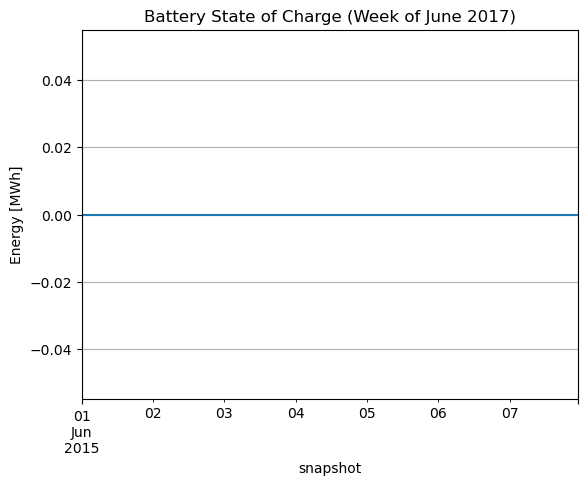

In [27]:
network.storage_units_t.state_of_charge["battery"].loc["2015-06-01":"2015-06-07"].plot()
plt.title("Battery State of Charge (Week of June 2017)")
plt.ylabel("Energy [MWh]")
plt.grid()
plt.show()
